In [91]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [25]:
k = 10
eps = 0.01
qa = np.zeros(k)
na = np.zeros(k)

In [42]:
def gen_reward(k, A, qs = []):
    if len(qs) == 0:
        qs = np.random.normal(0,1,k)
    
    reward = np.random.normal(qs[A], 1)
    
    return reward, qs

In [98]:
def gen_reward_nonstat(k, A, qs = []):
    if len(qs) == 0:
        qs = np.ones(k)
    
    qs+=np.random.normal(0, 0.01, k)
    
    reward = qs[A]
    
    return reward, qs

In [147]:
def train(k, eps, reward_fn, epochs=1000, step_size=-1, opt=-1):
    if opt == -1:
        qa = np.zeros(k)
    else:
        qa = np.ones(k)*opt
    na = np.zeros(k)
    qstar = []
    cumul_rew = []
    is_optimal = []
    for ep in range(epochs):
        chance = np.random.uniform(0,1)
        if chance > eps:
            A = np.random.choice(np.argwhere(qa == np.amax(qa)).flatten())
        else:
            A = np.random.randint(k)
            
        if ep != 0:
            optimal = np.argmax(qstar)
            is_optimal.append((A == optimal))
        
        R, qstar = reward_fn(k, A, qs=qstar)
        
        na[A]+=1
        
        if step_size == -1:
            qa[A]+=(1/na[A])*(R-qa[A])
        else:
            qa[A]+=step_size*(R-qa[A])

        cumul_rew.append(R)
        
    return np.array(cumul_rew), np.array(is_optimal)

In [100]:
exps_greedy = np.array([train(10, 0, gen_reward) for _ in tqdm(range(500))]) 

In [93]:
exps_01 = np.array([train(10, 0.1, gen_reward) for _ in tqdm(range(500))]) 

In [94]:
exps_001 = np.array([train(10, 0.01, gen_reward) for _ in tqdm(range(500))]) 

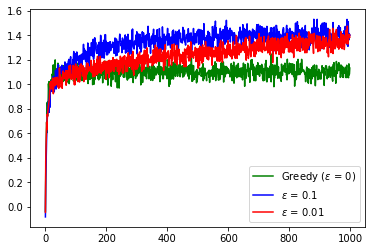

In [101]:
plt.plot(np.arange(1000), np.mean(exps_greedy[:,0], axis=0), c='g', label='Greedy ($\\epsilon$ = 0)')
plt.plot(np.arange(1000), np.mean(exps_01[:, 0], axis=0), c='b', label='$\\epsilon$ = 0.1')
plt.plot(np.arange(1000), np.mean(exps_001[:,0], axis=0), c='r', label='$\\epsilon$ = 0.01')
plt.legend()
plt.show()

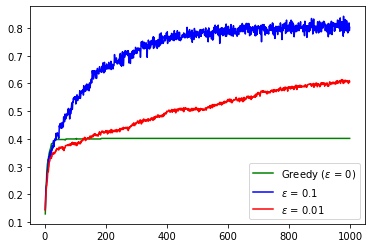

In [102]:
plt.plot(np.arange(1,1000), np.mean(exps_greedy[:,1]*1., axis=0), c='g', label='Greedy ($\\epsilon$ = 0)')
plt.plot(np.arange(1,1000), np.mean(exps_01[:, 1]*1., axis=0), c='b', label='$\\epsilon$ = 0.1')
plt.plot(np.arange(1,1000), np.mean(exps_001[:,1]*1., axis=0), c='r', label='$\\epsilon$ = 0.01')
plt.legend()
plt.show()

In [148]:
exps_opt = np.array([train(10, 0, gen_reward, step_size=0.1, opt=5) for _ in tqdm(range(500))]) 
exps_realist = np.array([train(10, 0.1, gen_reward, step_size=0.1) for _ in tqdm(range(500))]) 

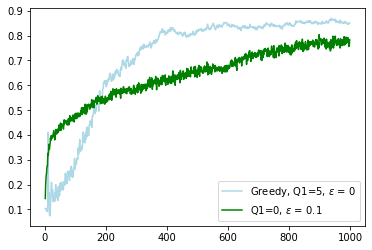

In [152]:
plt.plot(np.arange(1,1000), np.mean(exps_opt[:,1]*1., axis=0), c='lightblue', label='Greedy, Q1=5, $\\epsilon$ = 0')
plt.plot(np.arange(1,1000), np.mean(exps_realist[:, 1]*1., axis=0), c='g', label='Q1=0, $\\epsilon$ = 0.1')
plt.legend()
plt.show()

In [117]:
exps_nonstat_avg = np.array([train(10, 0.1, gen_reward_nonstat, epochs=10000) for _ in tqdm(range(500))]) 

In [118]:
exps_nonstat_step = np.array([train(10, 0.1, gen_reward_nonstat, step_size=0.1, epochs=10000) for _ in tqdm(range(500))]) 

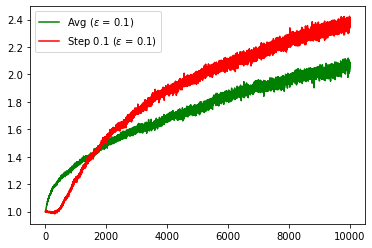

In [119]:
plt.plot(np.arange(10000), np.mean(exps_nonstat_avg[:,0], axis=0), c='g', label='Avg ($\\epsilon$ = 0.1)')
plt.plot(np.arange(10000), np.mean(exps_nonstat_step[:,0], axis=0), c='r', label='Step 0.1 ($\\epsilon$ = 0.1)')
plt.legend()
plt.show()

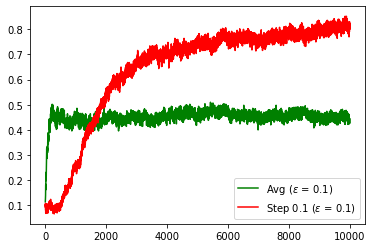

In [120]:
plt.plot(np.arange(1,10000), np.mean(exps_nonstat_avg[:,1]*1., axis=0), c='g', label='Avg ($\\epsilon$ = 0.1)')
plt.plot(np.arange(1,10000), np.mean(exps_nonstat_step[:,1]*1., axis=0), c='r', label='Step 0.1 ($\\epsilon$ = 0.1)')
plt.legend()
plt.show()

In [139]:
def train_UCB(k, c, reward_fn, epochs=1000, step_size=-1):
    qa = np.zeros(k)
    na = np.zeros(k)
    qstar = []
    cumul_rew = []
    is_optimal = []
    for ep in range(epochs):      
        rule = np.zeros(k)
        max_idxs = []
        for i in range(k):
            if na[i] == 0:
                max_idxs.append(i)
            else:
                rule[i] = qa[i]+ c*np.sqrt(np.log(ep)/na[i])

        rule[max_idxs] = np.amax(rule)+1

        A = np.random.choice(np.argwhere(rule == np.amax(rule)).flatten())
            
        if ep != 0:
            optimal = np.argmax(qstar)
            is_optimal.append((A == optimal))
        
        R, qstar = reward_fn(k, A, qs=qstar)
        
        na[A]+=1
        
        if step_size == -1:
            qa[A]+=(1/na[A])*(R-qa[A])
        else:
            qa[A]+=step_size*(R-qa[A])

        cumul_rew.append(R)
        
    return np.array(cumul_rew), np.array(is_optimal)

In [140]:
exps_UCB = np.array([train_UCB(10, 2, gen_reward) for _ in tqdm(range(500))]) 

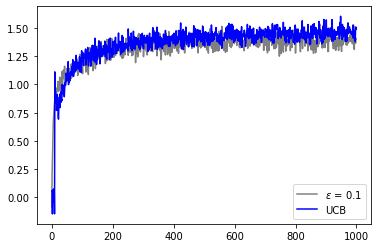

In [141]:
plt.plot(np.arange(1000), np.mean(exps_01[:, 0], axis=0), c='grey', label='$\\epsilon$ = 0.1')
plt.plot(np.arange(1000), np.mean(exps_UCB[:, 0], axis=0), c='b', label='UCB')
plt.legend()
plt.show()

In [143]:
def train_grad(k, reward_fn, epochs=1000, step_size=-1):
    ha = np.zeros(k)
    na = np.zeros(k)
    qstar = []
    cumul_rew = []
    is_optimal = []
    options = np.arange(k)
    for ep in range(epochs):      
        probs = np.exp(ha)/np.sum(np.exp(ha))
        A = np.random.choice(options, p=probs)
            
        R, qstar = reward_fn(k, A, qs=qstar)
        
        if ep != 0:
            optimal = np.argmax(qstar)
            is_optimal.append((A == optimal))
            
            Rbar = np.mean(cumul_rew)
        else:
            Rbar = R
        
        na[A]+=1
        
        for a in options:
            if a == A:
                ha[a]+= step_size*(R-Rbar)*(1-probs[a])
            else:
                ha[a]-= step_size*(R-Rbar)*probs[a]
        
        cumul_rew.append(R)
        
    return np.array(cumul_rew), np.array(is_optimal)

In [144]:
exps_grad= np.array([train_grad(10, gen_reward, step_size=0.1) for _ in tqdm(range(500))]) 

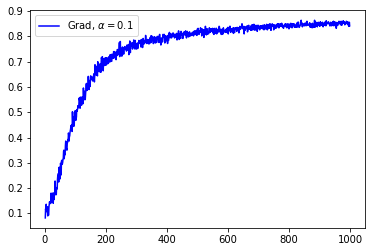

In [146]:
plt.plot(np.arange(1,1000), np.mean(exps_grad[:, 1]*1., axis=0), c='b', label='Grad, $\\alpha=0.1$')
plt.legend()
plt.show()

In [154]:
q0s = [1/4., 1/2., 1., 2., 4.]
eps_vals = [1/128., 1/64., 1/32., 1/16., 1/8., 1/4.]
c_vals = [1/16., 1/4., 1/2., 1., 2., 4.]
alphas = [1/32., 1/16., 1/8., 1/4., 1/2., 1., 2., 3.]

In [196]:
n_exp = 500

In [197]:
#optimistic
opt_vals_tb = np.array([np.array([train(10, 0, gen_reward, opt=q0) for _ in range(n_exp)]) for q0 in tqdm(q0s)])

#eps-greedy, avg
egreed_vals = np.array([np.array([train(10, eps, gen_reward) for _ in range(n_exp)])for eps in tqdm(eps_vals)])

#eps-greedy, const step
egreed_vals_const = np.array([np.array([train(10, eps, gen_reward, step_size=0.1) for _ in range(n_exp)]) for eps in tqdm(eps_vals)])

#UCB
ucb_vals = np.array([np.array([train_UCB(10, c, gen_reward) for _ in range(n_exp)]) for c in tqdm(c_vals)])

#gradient
grad_vals = np.array([np.array([train_grad(10, gen_reward, step_size=alpha) for _ in range(n_exp)]) for alpha in tqdm(alphas)])

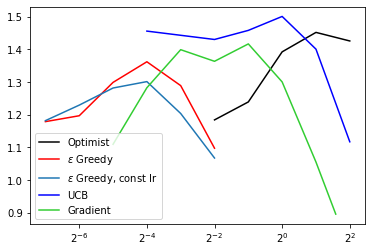

In [199]:
plt.plot(q0s, [np.mean([np.mean(opt_vals_tb[i,j, 0]) for j in range(n_exp)])
               for i in range(len(q0s))], c='k', label='Optimist')
plt.plot(eps_vals, [np.mean([np.mean(egreed_vals[i,j, 0]) for j in range(n_exp)])
                    for i in range(len(eps_vals))], c='r', label='$\\epsilon$ Greedy')
plt.plot(eps_vals, [np.mean([np.mean(egreed_vals_const[i,j, 0]) for j in range(n_exp)])
                    for i in range(len(eps_vals))], label='$\\epsilon$ Greedy, const lr')
plt.plot(c_vals, [np.mean([np.mean(ucb_vals[i,j, 0]) for j in range(n_exp)])
                  for i in range(len(c_vals))], c='b', label='UCB')
plt.plot(alphas, [np.mean([np.mean(grad_vals[i,j, 0]) for j in range(n_exp)])
                  for i in range(len(alphas))], c='limegreen', label='Gradient')

plt.xscale('log', basex=2)
plt.legend()
plt.show()